In [1]:
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg19 import VGG19, preprocess_input
import tensorflow.keras.applications as tfka

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import shutil
from glob import glob
# Helper libraries
import matplotlib.pyplot as plt
import math
%matplotlib inline
print(tf.__version__)

Using TensorFlow backend.


2.2.0


In [2]:
data_root='/kaggle/input/corona-ct/'
path_positive_cases = os.path.join('/kaggle/input/corona-ct/CT_COVID/')
path_negative_cases = os.path.join('/kaggle/input/corona-ct/CT_NonCOVID/')

In [3]:
# jpg and png files
positive_images_ls = glob(os.path.join(path_positive_cases,"*.png"))

negative_images_ls = glob(os.path.join(path_negative_cases,"*.png"))
negative_images_ls.extend(glob(os.path.join(path_negative_cases,"*.jpg")))

In [4]:
covid = {'class': 'CT_COVID',
         'path': path_positive_cases,
         'images': positive_images_ls}

non_covid = {'class': 'CT_NonCOVID',
             'path': path_negative_cases,
             'images': negative_images_ls}

In [5]:
total_positive_covid = len(positive_images_ls)
total_negative_covid = len(negative_images_ls)
print("Total Positive Cases Covid19 images: {}".format(total_positive_covid))
print("Total Negative Cases Covid19 images: {}".format(total_negative_covid))

Total Positive Cases Covid19 images: 349
Total Negative Cases Covid19 images: 388


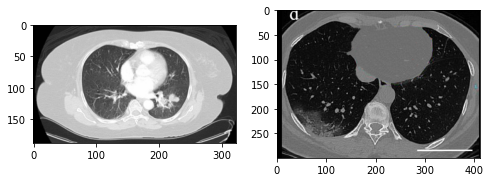

In [6]:
image_positive = cv2.imread(os.path.join(positive_images_ls[1]))
image_negative = cv2.imread(os.path.join(negative_images_ls[5]))

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(image_negative)
f.add_subplot(1,2, 2)
plt.imshow(image_positive)

In [7]:
print("Image COVID Shape {}".format(image_positive.shape))
print("Image Non COVID Shape {}".format(image_negative.shape))

Image COVID Shape (300, 412, 3)
Image Non COVID Shape (189, 323, 3)


In [8]:
# Create Train-Test Directory
subdirs  = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['CT_COVID', 'CT_NonCOVID']
    for labldir in labeldirs:
        newdir = subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [9]:
# Copy Images to test set

# seed random number generator
random.seed(123)
# define ratio of pictures used for testing 
test_ratio = 0.1


for cases in [covid, non_covid]:
    total_cases = len(cases['images']) #number of total images
    num_to_select = int(test_ratio * total_cases) #number of images to copy to test set
    
    print(cases['class'], num_to_select)
    
    list_of_random_files = random.sample(cases['images'], num_to_select) #random files selected

    for files in list_of_random_files:
        shutil.copy2(files, 'test/' + cases['class'])

CT_COVID 34
CT_NonCOVID 38


In [10]:
# Copy Images to train set
for cases in [covid, non_covid]:
    image_test_files = os.listdir('test/' + cases['class']) # list test files 
    for images in cases['images']:
        if images.split('/')[-1] not in (image_test_files): #exclude test files from shutil.copy
            shutil.copy2(images, 'train/' + cases['class'])

In [11]:
total_train_covid = len(os.listdir('/kaggle/working/train/CT_COVID'))
total_train_noncovid = len(os.listdir('/kaggle/working/train/CT_NonCOVID'))
total_test_covid = len(os.listdir('/kaggle/working/test/CT_COVID'))
total_test_noncovid = len(os.listdir('/kaggle/working/test/CT_NonCOVID'))

print("Train sets images COVID: {}".format(total_train_covid))
print("Train sets images Non COVID: {}".format(total_train_noncovid))
print("Test sets images COVID: {}".format(total_test_covid))
print("Test sets images Non COVID: {}".format(total_test_noncovid))

Train sets images COVID: 315
Train sets images Non COVID: 350
Test sets images COVID: 34
Test sets images Non COVID: 38


In [12]:
batch_size = 128
epochs = 15
#SHUFFLE_BUFFER_SIZE = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [13]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [14]:
train_dir = os.path.join('/kaggle/working/train')
test_dir = os.path.join('/kaggle/working/test')


total_train = total_train_covid + total_train_noncovid
total_test = total_test_covid + total_test_noncovid

In [15]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 665 images belonging to 2 classes.


In [16]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 72 images belonging to 2 classes.


In [17]:

# Create the base model from the pre-trained model MobileNet V2
#base_learning_rate = 0.0001
base_model = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False,
                                               weights='imagenet')

#kernel_regularizer=keras.regularizers.l2(l=0.05)
#regularizer_histories['model'] = compile_and_fit(model, "regularizers/l2")

29089792/29084464 [==============================] - 1s 0us/step


In [18]:
#prediction_layer = tf.keras.layers.Dense(1)

#print(prediction_layer) 
base_model.trainable = False

In [19]:
model = tf.keras.Sequential([
 #IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

  base_model,
  #global_average_layer,
  #Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
  #MaxPooling2D(),
  #Conv2D(32, 3, padding='same', activation='relu'),
  #MaxPooling2D(),
  #Conv2D(64, 3, padding='same', activation='relu'),
  #Dropout(0.4),
  MaxPooling2D(),


  Flatten(),
  Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.05)),
  Dropout(0.3),
  Dense(1,kernel_regularizer=keras.regularizers.l2(l=0.05))
  #tf.keras.layers.Dense(1)
])



In [20]:
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

#model.trainable = False

#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)



In [21]:
#prediction_layer = tf.keras.layers.Dense(1)
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

In [22]:
#model = tf.keras.Sequential([
#  base_model,
  #global_average_layer,
#  prediction_layer
#])

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=(len(train_data_gen) / batch_size)*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [23]:
#model.compile(optimizer='adam',
            #  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             # metrics=['accuracy'])



model.compile(optimizer= get_optimizer(),#tf.keras.optimizers.RMSprop(lr=0.0001, momentum = 0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 4, 4, 1024)        7037504   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 9,135,681
Trainable params: 2,098,177
Non-trainable params: 7,037,504
______________________________________

In [25]:
history = model.fit(train_data_gen,
                    epochs=epochs,
                    validation_data=test_data_gen)

Epoch 1/15
6/6 [==============================] - 7s 1s/step - loss: 43.2171 - accuracy: 0.5504 - val_loss: 34.9074 - val_accuracy: 0.5556
Epoch 2/15
6/6 [==============================] - 5s 877ms/step - loss: 29.1297 - accuracy: 0.6496 - val_loss: 24.5583 - val_accuracy: 0.5972
Epoch 3/15
6/6 [==============================] - 4s 715ms/step - loss: 22.0105 - accuracy: 0.7233 - val_loss: 18.6080 - val_accuracy: 0.7500
Epoch 4/15
6/6 [==============================] - 4s 741ms/step - loss: 16.6388 - accuracy: 0.6902 - val_loss: 14.6327 - val_accuracy: 0.6528
Epoch 5/15
6/6 [==============================] - 4s 700ms/step - loss: 13.4976 - accuracy: 0.7654 - val_loss: 11.9280 - val_accuracy: 0.7222
Epoch 6/15
6/6 [==============================] - 4s 705ms/step - loss: 10.9225 - accuracy: 0.7895 - val_loss: 10.1283 - val_accuracy: 0.6944
Epoch 7/15
6/6 [==============================] - 4s 688ms/step - loss: 9.4543 - accuracy: 0.8075 - val_loss: 8.7973 - val_accuracy: 0.7222
Epoch 8/15


In [26]:
#save